In [1]:
import numpy as np
import matplotlib.pyplot as plt
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import seaborn as sns
import pandas as pd
from torchsummary import summary
from torch.autograd import Variable
from torch.utils.data import random_split
from torch.utils.data import DataLoader, TensorDataset


In [2]:
# import the dataset
raw_train_data = pd.read_csv('./SL Dataset/sign_mnist_train/sign_mnist_train.csv', sep=",")
raw_test_data = pd.read_csv('./SL Dataset/sign_mnist_test/sign_mnist_test.csv', sep=",")

In [4]:
print(raw_train_data.shape)
print(raw_test_data.shape)
print()
print(raw_train_data.head(5))

(27455, 785)
(7172, 785)

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133       163   

   pixel781  pixel782  pixel783  pixel784  
0   

In [5]:
# Create a dictionary to show output as letters
alphabet = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:"F", 6:'G',
             7:'H', 8:'I', 9:'J', 10:'K', 11:'L', 12:'M', 13:'N',
        14:'O', 15:'P', 16:'Q', 17:'R', 18:'S', 19:'T', 20:'U', 21:'V', 
             22:'W', 23:'X', 24:'Y', 25:'Z'}

In [6]:
# Convert to 2D nummpy arrays
def Data2NParray(train_data, test_data):
    train = train_data.copy(deep = True)
    test = test_data.copy(deep = True)
    train_img = train.iloc[:, 1:].to_numpy(dtype = 'float32')
    test_img = test.iloc[:, 1:].to_numpy(dtype = 'float32')
    return train_img, test_img

In [7]:
train_img, test_img = Data2NParray(raw_train_data, raw_test_data)
train_labels = raw_train_data['label'].values
test_labels = raw_test_data['label'].values

In [8]:
print(train_img.size)
print('\n\n')
print(test_img.shape[0])
print('\n\n')
print(train_labels)
print('\n\n')
print(test_labels)

21524720



7172



[ 3  6  2 ... 18 17 23]



[ 6  5 10 ...  2  4  2]


In [9]:
# Reshape the images to 3d array of 1, 28, 28
train_img = train_img.reshape(train_img.shape[0], 1, 28, 28)
test_img = test_img.reshape(test_img.shape[0], 1, 28, 28)

In [10]:
# Convert Numpy arrays into tensors
train_img_tensor = torch.from_numpy(train_img)
test_img_tensor = torch.from_numpy(test_img)

train_label_tensor = torch.from_numpy(train_labels)
test_label_tensor = torch.from_numpy(test_labels)

In [11]:
# Convert to a pytorch Dataset
training_Dataset = TensorDataset(train_img_tensor, train_label_tensor)
test_Dataset = TensorDataset(test_img_tensor, test_label_tensor)

In [12]:
# Each image is now converted to a (1,28,28) tensor
image, label = training_Dataset[0]
print(len(training_Dataset), image.shape, label)

27455 torch.Size([1, 28, 28]) tensor(3)


In [13]:
img, label = training_Dataset[0]
print(img.shape, label)
img

torch.Size([1, 28, 28]) tensor(3)


tensor([[[107., 118., 127., 134., 139., 143., 146., 150., 153., 156., 158.,
          160., 163., 165., 159., 166., 168., 170., 170., 171., 171., 171.,
          172., 171., 171., 170., 170., 169.],
         [111., 121., 129., 135., 141., 144., 148., 151., 154., 157., 160.,
          163., 164., 170., 119., 152., 171., 171., 170., 171., 172., 172.,
          172., 172., 172., 171., 171., 170.],
         [113., 123., 131., 137., 142., 145., 150., 152., 155., 158., 161.,
          163., 164., 172., 105., 142., 170., 171., 171., 171., 172., 172.,
          173., 173., 172., 171., 171., 171.],
         [116., 125., 133., 139., 143., 146., 151., 153., 156., 159., 162.,
          163., 167., 167.,  95., 144., 171., 172., 172., 172., 172., 172.,
          173., 173., 173., 172., 172., 171.],
         [117., 126., 134., 140., 145., 149., 153., 156., 158., 161., 163.,
          164., 175., 156.,  87., 154., 172., 173., 173., 173., 173., 173.,
          174., 174., 174., 173., 172., 172.],
     

In [14]:
# Create validation set and training set
validation_sz = 7455
training_sz = len(training_Dataset) - validation_sz

training_set, validation_set = random_split(training_Dataset, [training_sz, validation_sz])

len(validation_set), len(training_set), len(test_Dataset)

(7455, 20000, 7172)

In [15]:
# Set Hyperparameters
batch_size = 60
learning_rate = 0.001
num_epochs = 10
opt_func = torch.optim.SGD


In [16]:
random_seed = 15
torch.manual_seed(random_seed);

In [17]:
# Create DataLoaders for training and validation
train_dl = DataLoader(training_set, batch_size, shuffle = True, num_workers=4, pin_memory=True)
validation_dl = DataLoader(validation_set, batch_size*2, shuffle = True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_Dataset, batch_size*2, num_workers=4, pin_memory=True)

In [18]:
# Create Network class and make helper methods for training and validation
class Network(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        # Generate Predictions
        out = self(images)
        # Calculate Loss
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        # Generate Predictions
        out = self(images)
        # Calculate Loss
        loss = F.cross_entropy(out, labels)
        # Calculate Accuracy
        acc = accuracy(out, labels)
        return{'val_loss': loss.detach(),'val_accuracy': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        # Combine Losses
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['val_accuracy'] for x in outputs]
        # Combine Accuracies
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss': epoch_loss.item(), 'val_accuracy': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train loss: {:.3f}, val loss {:.3f}, val acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_accuracy']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
        

In [19]:
class CNNModel(Network):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels, 28, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(28, 28, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # Ouput image size: 28x14x14

            nn.Conv2d(28, 56, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(56, 56, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # Ouput image size: 56x7x7

            nn.Flatten(),
            nn.Linear(56*7*7, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))
    
    def forward(self, xb):
        return self.network(xb)

In [20]:
# Constants for training Model
input_ch = 1
input_size = input_ch * 28 * 28
classes = 26

In [21]:
model = CNNModel(input_ch, classes)
model

CNNModel(
  (network): Sequential(
    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(28, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=2744, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=128, bias=True)
    (14): ReLU()
    (15): Linear(in_features=128, out_features=26, bias=True)
  )
)

In [22]:
    
def to_device(data, device):
    # Move Tensors to a chosen device
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    # Move Data to the device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)
            
    def __len(self):
        # Number of batches
        return len(self.dl)
    

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [24]:
model = to_device(CNNModel(input_ch, classes), device)

In [25]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(validation_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

print(train_dl.device)
print(test_dl.device)
print(val_dl.device)

cuda
cuda
cuda


In [26]:
# Training the Model

@torch.no_grad()
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [27]:
evaluate(model, val_dl)

{'val_loss': 3.3297271728515625, 'val_accuracy': 0.034656085073947906}

In [28]:
history = fit(num_epochs, learning_rate , model, train_dl, val_dl, opt_func)


Epoch [0], train loss: 3.111, val loss 3.069, val acc: 0.1078
Epoch [1], train loss: 2.224, val loss 2.219, val acc: 0.3351
Epoch [2], train loss: 1.117, val loss 1.070, val acc: 0.6690
Epoch [3], train loss: 0.570, val loss 0.499, val acc: 0.8200
Epoch [4], train loss: 0.276, val loss 0.154, val acc: 0.9606
Epoch [5], train loss: 0.126, val loss 0.343, val acc: 0.8987
Epoch [6], train loss: 0.058, val loss 0.107, val acc: 0.9661
Epoch [7], train loss: 0.048, val loss 0.022, val acc: 0.9989
Epoch [8], train loss: 0.014, val loss 0.020, val acc: 0.9984
Epoch [9], train loss: 0.009, val loss 0.008, val acc: 0.9999


In [29]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

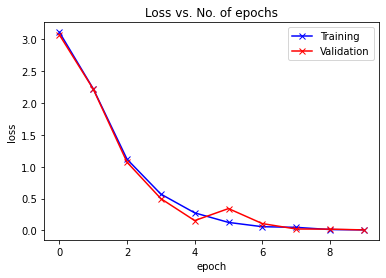

In [30]:
plot_losses(history)


In [31]:
# Test with the tesing dataloader
result = evaluate(model, test_dl)
result

{'val_loss': 0.42141038179397583, 'val_accuracy': 0.8872584700584412}

In [32]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return preds[0].item()

In [33]:
for x in range(10):
    img, label = test_Dataset[x]
    print('Label:', label, ', Predicted:', predict_image(img, model))
    

Label: tensor(6) , Predicted: 6
Label: tensor(5) , Predicted: 5
Label: tensor(10) , Predicted: 10
Label: tensor(0) , Predicted: 0
Label: tensor(3) , Predicted: 3
Label: tensor(21) , Predicted: 22
Label: tensor(10) , Predicted: 10
Label: tensor(14) , Predicted: 14
Label: tensor(3) , Predicted: 3
Label: tensor(7) , Predicted: 7


In [107]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "ayon-chakroborty/cardano-cnn-revised" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/ayon-chakroborty/cardano-cnn-revised


'https://jovian.ai/ayon-chakroborty/cardano-cnn-revised'

In [34]:
# Save Pytorch Model
FILE = "/home/ayon_chakroborty/Desktop/Cardano DNN/model2.pth"
torch.save(model.state_dict(), FILE)

In [35]:
# Load the saved Model
loaded_model = CNNModel(input_ch, classes)
loaded_model.load_state_dict(torch.load(FILE))
loaded_model.eval()

CNNModel(
  (network): Sequential(
    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(28, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=2744, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=128, bias=True)
    (14): ReLU()
    (15): Linear(in_features=128, out_features=26, bias=True)
  )
)

In [36]:
# Test the loaded Model
loaded_model = to_device(loaded_model, device)
for x in range(10):
    img, label = test_Dataset[x]
    print('Label:', label, ', Predicted:', predict_image(img, loaded_model))

Label: tensor(6) , Predicted: 6
Label: tensor(5) , Predicted: 5
Label: tensor(10) , Predicted: 10
Label: tensor(0) , Predicted: 0
Label: tensor(3) , Predicted: 3
Label: tensor(21) , Predicted: 22
Label: tensor(10) , Predicted: 10
Label: tensor(14) , Predicted: 14
Label: tensor(3) , Predicted: 3
Label: tensor(7) , Predicted: 7


In [37]:
# Test the loaded Model with test dataset
ld_result = evaluate(loaded_model, test_dl)
ld_result

{'val_loss': 0.42141038179397583, 'val_accuracy': 0.8872584700584412}

In [122]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "ayon-chakroborty/cardano-cnn-revised" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/ayon-chakroborty/cardano-cnn-revised


'https://jovian.ai/ayon-chakroborty/cardano-cnn-revised'

In [38]:
onnx_model_path = "/home/ayon_chakroborty/Desktop/Cardano DNN/CNNmodel_version_2.onnx"
x = torch.randn(1, 1, 28, 28, device='cuda') # Sample input in the shape that the model expects
torch.onnx.export(model, x, onnx_model_path, verbose=True)

graph(%input.1 : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cuda:0),
      %network.0.weight : Float(28, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cuda:0),
      %network.0.bias : Float(28, strides=[1], requires_grad=1, device=cuda:0),
      %network.2.weight : Float(28, 28, 3, 3, strides=[252, 9, 3, 1], requires_grad=1, device=cuda:0),
      %network.2.bias : Float(28, strides=[1], requires_grad=1, device=cuda:0),
      %network.5.weight : Float(56, 28, 3, 3, strides=[252, 9, 3, 1], requires_grad=1, device=cuda:0),
      %network.5.bias : Float(56, strides=[1], requires_grad=1, device=cuda:0),
      %network.7.weight : Float(56, 56, 3, 3, strides=[504, 9, 3, 1], requires_grad=1, device=cuda:0),
      %network.7.bias : Float(56, strides=[1], requires_grad=1, device=cuda:0),
      %network.11.weight : Float(512, 2744, strides=[2744, 1], requires_grad=1, device=cuda:0),
      %network.11.bias : Float(512, strides=[1], requires_grad=1, device=cuda: